In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import corner
import plotting_utils as plotting
import uncertainty_utils as uncertain
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Read in pre-training and post-training metadata

In [2]:
from types import SimpleNamespace
import json
import torch

meta = json.load(open("data_meta.txt"))
args = json.load(open("args.txt"))

# Configure device, same as trained model
device = torch.device(type=meta['device_type'])
if device=='cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

### Read in validation dataset

In [3]:
# Full dataset
X = np.load('data/X.npy')
Y = np.load('data/Y.npy')

# Validation set
X_val = X[meta['val_indices'], :]
Y_val = Y[meta['val_indices'], :]

In [4]:
import models
from torch.autograd import Variable

length_scale = args['l']
wr = length_scale**2.0/meta['n_train']
dr = 2.0/meta['n_train']

# I hardcoded CPU here b/c the whole validation set doesn't fit on my GPU
model = models.ConcreteDenseMixture(meta['X_dim'], meta['Y_dim'], args['n_features'], wr, dr).to(device)
checkpoint_path = 'checkpoints/weights_0_50.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model'])
model.eval()


ConcreteDenseMixture(
  (linear1): Linear(in_features=30, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=512, bias=True)
  (linear4_mu): Linear(in_features=512, out_features=20, bias=True)
  (linear4_logvar): Linear(in_features=512, out_features=20, bias=True)
  (linear4_F): Linear(in_features=512, out_features=40, bias=True)
  (linear4_mu2): Linear(in_features=512, out_features=20, bias=True)
  (linear4_logvar2): Linear(in_features=512, out_features=20, bias=True)
  (linear4_F2): Linear(in_features=512, out_features=40, bias=True)
  (linear4_alpha): Linear(in_features=512, out_features=1, bias=True)
  (linear4_mu_classifier): Linear(in_features=512, out_features=1, bias=True)
  (linear4_logvar_classifier): Linear(in_features=512, out_features=1, bias=True)
  (conc_drop1): ConcreteDropout()
  (conc_drop2): ConcreteDropout()
  (conc_drop3): ConcreteDropout()
  (conc_drop_mu): ConcreteDropou

In [5]:
import solver

with torch.no_grad():
    dropout_sample = solver.mc_sample(model, X_val, Y_val, args['n_MC'], device, args['cov_mat'])
pppp, rmse, mean_norm, logvar_norm = solver.get_scalar_metrics(dropout_sample['mean'], dropout_sample['logvar'], Y_val[:, 1:], args['n_MC'])
dropout_result = solver.average_over_dropout(dropout_sample)

In [10]:
X_nat, Y_nat, em_nat, em_nat_second = plotting.get_natural_units(X=X_val, Y=Y_val, meta=meta, **dropout_result)

/usr/local/lib/python3.5/dist-packages/astropy/units/function/logarithmic.py:44: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/home/jwp/stage/sl/LSSTDESC/fast-forward/plotting_utils.py:346: RuntimeWarning: invalid value encountered in power
  mu['%s_al_sig' %moment_type] = np.abs(0.5*mu.loc[:, moment_type].values**(-0.5)) * al_sig2[moment_type].values**0.5
/home/jwp/stage/sl/LSSTDESC/fast-forward/plotting_utils.py:347: RuntimeWarning: invalid value encountered in power
  mu['%s_ep_sig' %moment_type] = np.abs(0.5*mu.loc[:, moment_type].values**(-0.5)) * ep_sig2[moment_type].values**0.5
/home/jwp/stage/sl/LSSTDESC/fast-forward/plotting_utils.py:348: RuntimeWarning: invalid value encountered in power
  mu_second['%s_al_sig' %moment_type] = np.abs(0.5*mu_second.loc[:, moment_type].values**(-0.5)) * al_sig2_second[moment_type].values**0.5
/home/jwp/stage/sl/LSSTDESC/fast-forward/plotting_utils.py:349: RuntimeWarning: invalid value enco

In [6]:
sample = solver.sample_from_likelihood(dropout_result, n_sample=100)

In [7]:
sample.shape

(12701, 100, 20)

(array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.600e+01, 4.900e+01,
        5.900e+01, 9.100e+01, 1.190e+02, 1.520e+02, 1.860e+02, 2.730e+02,
        4.120e+02, 6.760e+02, 1.005e+03, 1.488e+03, 1.711e+03, 1.673e+03,
        1.421e+03, 1.172e+03, 8.680e+02, 5.510e+02, 3.410e+02, 1.960e+02,
        1.410e+02, 6.100e+01, 2.400e+01, 7.000e+00, 1.000e+00, 4.000e+00]),
 array([15.0259966 , 15.50708766, 15.98817872, 16.46926978, 16.95036084,
        17.4314519 , 17.91254296, 18.39363402, 18.87472508, 19.35581614,
        19.8369072 , 20.31799826, 20.79908932, 21.28018038, 21.76127144,
        22.2423625 , 22.72345356, 23.20454462, 23.68563568, 24.16672674,
        24.6478178 , 25.12890886, 25.60999992, 26.09109098, 26.57218204,
        27.0532731 , 27.53436416, 28.01545522, 28.49654628, 28.97763734,
        29.4587284 ]),
 <a list of 30 Patch objects>)

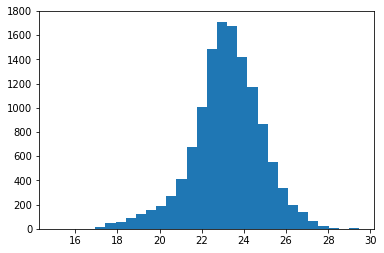

In [74]:
import astropy.units as u
plt.hist((X_nat['g_flux'].values * u.Jy).to_value(u.ABmag), bins=30)

In [11]:
def get_natural_units(arr, X_nat):
    import astropy.units as u
    X_cols = ['%s_flux' %bp for bp in 'ugrizy'] + ['ra_truth', 'dec_truth'] + ['star']
    X = X_nat[X_cols].values.reshape(-1, 1, len(X_cols)).repeat(100, axis=1)
    arr = np.concatenate([arr, X], axis=2)
    arr = arr.reshape(-1, 20 + len(X_cols))
    scale_flux = 1.e5
    df = pd.DataFrame(arr, index=None, columns=meta['Y_cols'][1:] + list(X_cols))
    df['Ixx'] *= df['Ixx']
    df['Iyy'] *= df['Iyy']
    df['ra_offset'] = df['ra_offset']/3600.0/1000.0
    df['dec_offset'] = df['dec_offset']/3600.0/1000.0
    df['ra_obs'] = df['ra_truth'] + df['ra_offset']
    df['dec_obs'] = df['dec_truth'] + df['dec_offset']
    cols = ['cModelFlux_%s' %bp for bp in 'ugrizy'] + ['psFlux_%s' %bp for bp in 'ugrizy']
    for col in cols:
        bp = col.split('_')[1]
        df['%s_mag' %col] = ((df[col].values/scale_flux + df['%s_flux' %bp].values) * u.Jy).to_value(u.ABmag)
    
    #df['cModelFlux_u_mag'] = (df['cModelFlux_u'].values /scale_flux * u.Jy).to_value(u.ABmag)
    #df['cModelFlux_g_mag'] = (df['cModelFlux_g'].values/scale_flux * u.Jy).to_value(u.ABmag) 
    #df['cModelFlux_r_mag'] = (df['cModelFlux_r'].values/scale_flux * u.Jy).to_value(u.ABmag)
    #df['cModelFlux_i_mag'] = (df['cModelFlux_i'].values/scale_flux * u.Jy).to_value(u.ABmag)
    #df['psFlux_u_mag'] = (df['psFlux_u'].values/scale_flux * u.Jy).to_value(u.ABmag)
    #df['psFlux_g_mag'] = (df['psFlux_g'].values/scale_flux * u.Jy).to_value(u.ABmag)
    #df['psFlux_r_mag'] = (df['psFlux_r'].values/scale_flux * u.Jy).to_value(u.ABmag)
    #df['psFlux_i_mag'] = (df['psFlux_i'].values/scale_flux * u.Jy).to_value(u.ABmag)
    
    df = df.loc[~df.isnull().any(1), :]
    return df

In [14]:
sample_df = get_natural_units(sample, X_nat).reset_index()

/usr/local/lib/python3.5/dist-packages/astropy/units/function/logarithmic.py:44: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


11468 6
176164 6


ValueError: color kwarg must have one color per dataset

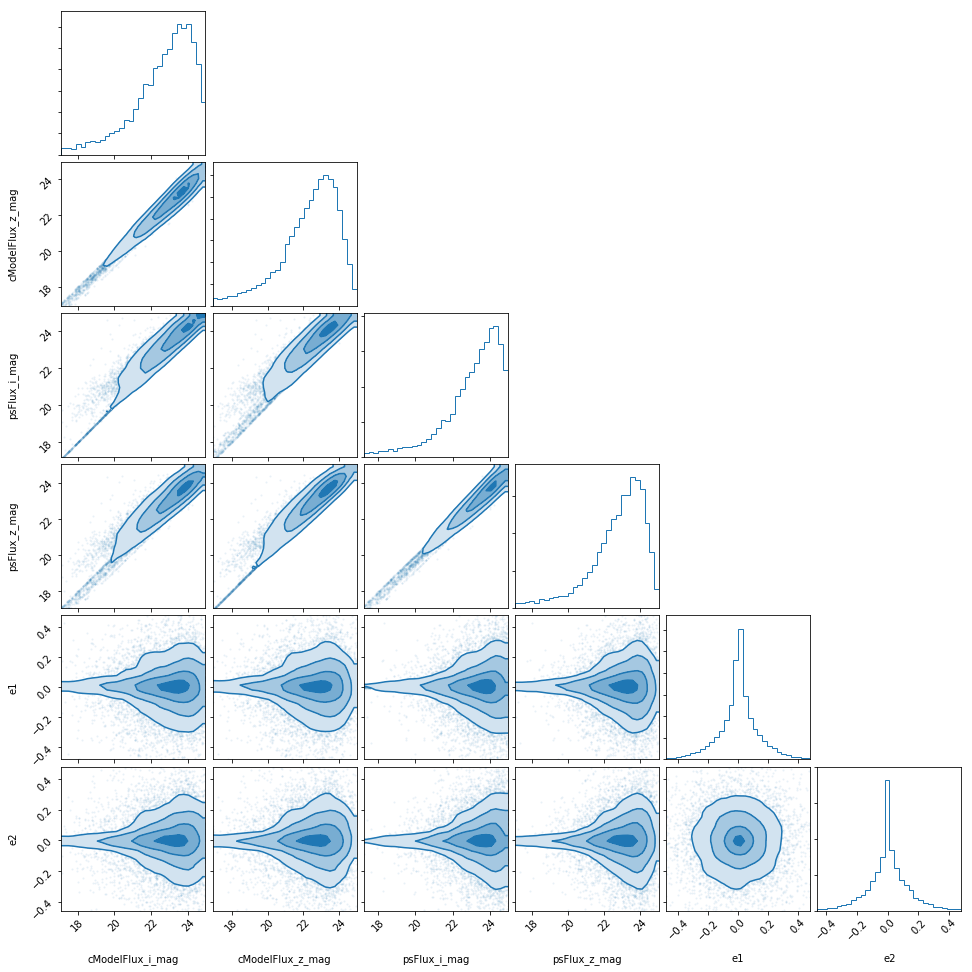

In [15]:
def draw_cornerplot(df, fig=None, color='black'):
    #plotting_cols = ['e1', 'e2', 'ug_cModelFlux', 'gr_cModelFlux', 'ri_cModelFlux',
    #   'ug_psFlux', 'gr_psFlux', 'ri_psFlux']
    plotting_cols = ['cModelFlux_%s_mag' %bp for bp in 'iz'] + ['psFlux_%s_mag' %bp for bp in 'iz'] + ['e1', 'e2']
    #plotting_cols = ['Ixx', 'Iyy', 'Ixx',] +  ['cModelFlux_%s_mag' %bp for bp in 'gri'] +\
    # ['psFlux_%s_mag' %bp for bp in 'griz']
    df['e1'] = (df['Ixx'] - df['Iyy'])/(df['Ixx'] + df['Iyy'])
    df['e2'] = 2.0*df['Ixy']/(df['Ixx'] + df['Iyy'])
    df['ug_cModelFlux'] = df['cModelFlux_u_mag'] - df['cModelFlux_g_mag']
    df['gr_cModelFlux'] = df['cModelFlux_g_mag'] - df['cModelFlux_r_mag']
    df['ri_cModelFlux'] = df['cModelFlux_r_mag'] - df['cModelFlux_i_mag']
    
    df['ug_psFlux'] = df['psFlux_u_mag'] - df['psFlux_g_mag']
    df['gr_psFlux'] = df['psFlux_g_mag'] - df['psFlux_r_mag']
    df['ri_psFlux'] = df['psFlux_r_mag'] - df['psFlux_i_mag']
    
    mask = ~df.isnull().any(1)
    df = df.loc[mask, plotting_cols].values
    
    n_obj, n_params = df.shape
    print(n_obj, n_params)
    plot = corner.corner(df,
                        color=color, 
                        smooth=1.0, 
                        labels=plotting_cols,
                        #show_titles=True,
                        fill_contours=True,
                        bins=30,
                        fig=fig,
                        range=[0.99]*n_params,
                        hist_kwargs=dict(density=True, ))
    return plot

pairwise_Y = draw_cornerplot(Y_nat, color='tab:blue')
pairwise_emulated = draw_cornerplot(sample_df, fig=pairwise_Y, color='tab:orange')

In [52]:
good_mask = ~Y_val.isnull().any(axis=1)
good_idx = Y_val.index.values[good_mask]
#good_sampled_idx = np.random.choice(good_idx, size=200, replace=False)
good_sampled_idx = np.array([5182, 5208,  166, 6136, 3789, 1092, 6300, 3729, 6145,  258, 4318,
                           3006, 3917, 3206,  557, 2977, 4458, 6104, 2923, 3300, 3674,  734,
                           2997, 4865, 3988, 2008, 2031, 4745, 1259, 2730,  689, 2277, 4363,
                           2904, 3881, 2629, 4995, 5171, 4533, 5032, 4682, 2632, 2004, 4116,
                           6425, 6420, 4946, 5316, 5343, 2037, 1721,  616, 5492, 3975, 6188,
                           4107, 4416, 6157, 6700, 5909, 4529, 6511, 2582, 2823, 6229, 3629,
                           1722, 2627,  309, 3595, 2235, 5919, 1305, 3839, 6212, 2446, 4328,
                           3930, 4469,  456, 1377,  970, 5702, 4866, 4678, 3438, 5707, 1415,
                           3237, 3738, 5358, 5600, 1821, 3452, 6207, 5619,  378, 5929, 5928,
                           3647,  405, 2581, 2777, 3714, 6650,  403, 3573, 4110, 2386, 2196,
                           5579, 5698, 4896, 5373, 6006, 3520, 6560, 1900, 3797, 4709, 2041,
                           5416, 3733, 5741, 1957, 6355, 2973, 2070, 4918, 1947, 1242,  736,
                           5783, 4433, 5295,  949, 1258, 4196, 4445, 3687,  223, 3916, 2811,
                           3689, 6513, 3791, 5197, 5297, 5901, 4642, 5984, 2510, 5948,  695,
                             89, 6694, 2588, 3784, 6443,  404, 3437, 1027, 3243, 5103, 4150,
                           1373, 6618,  626, 3800, 1904, 3459,  794, 1634,  612, 5408, 6211,
                           1261, 3987, 2222, 5757, 1911, 2875, 2667, 5283, 3644, 5061, 4942,
                           6574, 6600, 3519, 6611, 2796, 6717, 1427,  509,  926, 1475, 2612,
                           5540, 3333])

X_val_good = X_val.loc[good_mask, :].reset_index()
Y_val_good = Y_val.loc[good_mask, :].reset_index()
mu_all_good = mu_all.loc[good_mask, :].reset_index()

In [60]:
bad_idx = Y_val.index.values[~good_mask]
#bad_sampled_idx = np.random.choice(Y_val.shape[0], size=50, replace=False)
bad_sampled_idx = [6518, 1300, 1309, 2134, 4271,  328, 4949,  989,  114, 4614, 3999,
                       4123, 5534, 3487,  290, 5782, 5260, 3012, 4186,  148, 2036, 2035,
                       4643, 1272, 2463, 5684, 1485, 2607, 1571, 6580, 5154,  228,  136,
                       3544, 5791, 1783, 6159, 6007, 6235,  744, 6566, 1813,  937, 5415,
                        624, 2506, 4460, 5383, 1187,  663]

In [ ]:

valid_idx = Y_val.index.values[].sample(n=3, random_state=1)


In [25]:
X_val.head()

,u_flux,g_flux,r_flux,i_flux,z_flux,y_flux,ra_truth,dec_truth,redshift,star,...,truth_total_mag_g,truth_gal_mag_g,truth_total_mag_r,truth_gal_mag_r,truth_total_mag_i,truth_gal_mag_i,truth_total_mag_z,truth_gal_mag_z,truth_total_mag_y,truth_gal_mag_y
0,2.370123e-06,2.592699e-06,0.000005,0.000011,0.000017,0.000020,55.917126,-28.788598,7.927755e-01,False,...,22.865620,24.493499,22.218988,23.412971,21.312424,22.348138,20.849169,21.790522,20.657638,21.525178
1,2.104239e-06,1.827455e-06,0.000002,0.000002,0.000002,0.000002,55.296734,-28.692456,8.830770e-01,False,...,23.245383,29.182461,23.412391,28.653373,23.153726,27.699809,23.130849,27.233066,23.212198,27.157113
2,6.171092e-07,9.081797e-07,0.000002,0.000003,0.000003,0.000003,56.145699,-29.132350,4.079199e-01,False,...,24.004571,24.908132,23.107562,23.949838,22.887232,23.578893,22.753849,23.371076,22.688658,23.204393
3,2.638858e-07,2.637923e-06,0.000008,0.000021,0.000033,0.000041,56.323654,-29.425158,9.009418e-09,True,...,22.846845,-1.000000,21.639764,-1.000000,20.576652,-1.000000,20.089010,-1.000000,19.873663,-1.000000
4,5.938733e-05,1.791921e-04,0.000263,0.000300,0.000310,0.000315,55.001320,-28.393288,9.009418e-09,True,...,18.266703,-1.000000,17.849151,-1.000000,17.708704,-1.000000,17.671633,-1.000000,17.654659,-1.000000


In [ ]:

# Subsample for visualization
np.random.seed(123)
n_subsample = 200
subsampled = np.random.choice(Y_val.shape[0], size=n_subsample, replace=False)
X_val_sampled = X_val[subsampled, :] # shape [n_subsampled, X_dim]
Y_val_sampled = Y_val[subsampled, :] # shape [n_subsampled, Y_dim]

In [ ]:
import units_utils as units
import astropy.units as u
from uncertainty_utils import *
from collections import OrderedDict



In [30]:
~np.isnan(X).any(axis=1)


array([ True,  True,  True, ...,  True,  True,  True])

In [5]:
Y_coldict = dict(zip(meta.Y_cols, range(meta.Y_dim)))
X_coldict = dict(zip(meta.X_cols, range(meta.X_dim)))

### Compare star fraction between entire dataset and validation set

In [6]:
print(X_val[:, X_coldict['not_star']].sum()/X_val.shape[0])

print(X[:, X_coldict['not_star']].sum()/X.shape[0])

0.8000705840832892
0.7967603049124788


In [ ]:
np.isfinite

In [71]:
d = pd.DataFrame({'a': [1,2,3], 'b': [4,5,6]})
d.loc[:, 'b'].isnull()

0    False
1    False
2    False
Name: b, dtype: bool

In [66]:
d.isnull().any(1).values

array([False, False, False])

### Prediction time!

In [7]:
meta.run_id

0

In [8]:


#X_val.mean()

#X_val.columns

In [14]:
#OrderedDict(zip(meta.Y_cols, np.mean(np.mean(means, axis=0), axis=0)))

### Plot single-quantity marginal posterior

### Plot pairwise marginal posterior

### Plot sampled posterior for a single object

In [29]:
diff_mom = arr[mask, Y_coldict['Ixx']]**2.0 - arr[mask, Y_coldict['Ixx']]**2.0
    trace_mom = arr[mask, Y_coldict['Ixx']]**2.0 + arr[mask, Y_coldict['Ixx']]**2.0
    e1 = diff_mom/trace_mom
    e2 = 2.0*arr[mask, Y_coldict['Ixy']]/trace_mom
    return e1, e2

AxisError: axis 1 is out of bounds for array of dimension 1

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


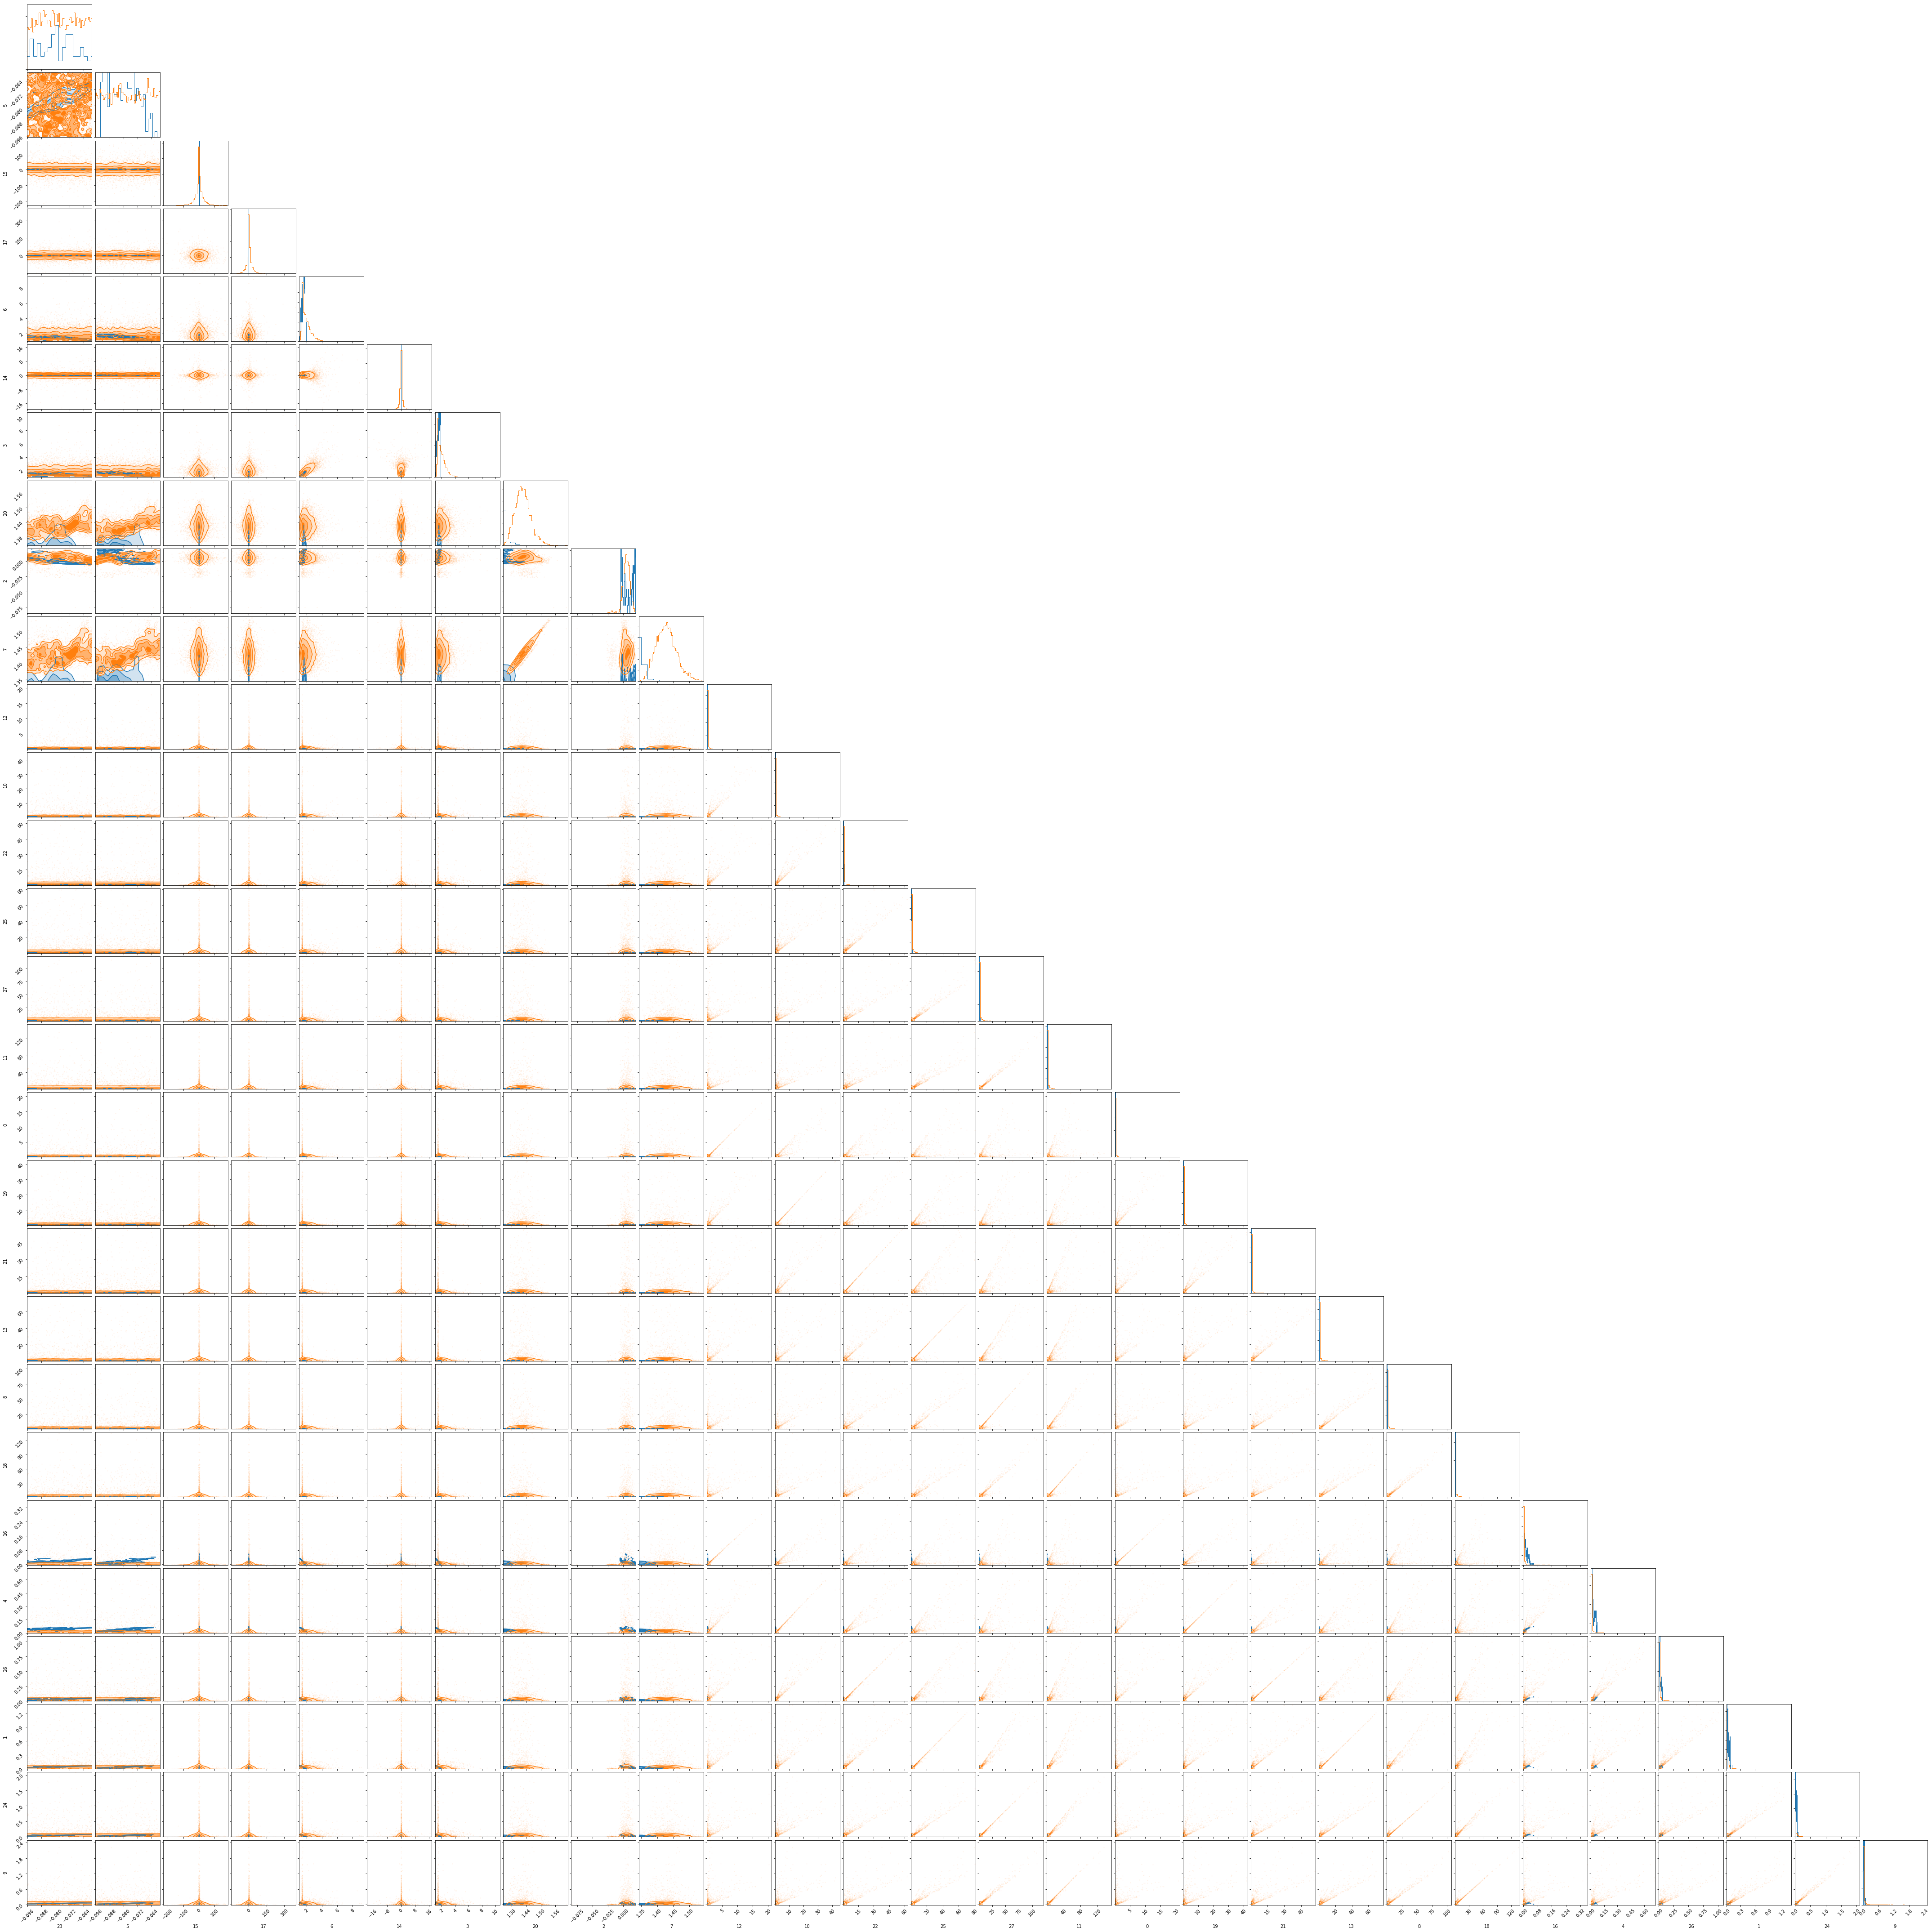

In [18]:
def draw_cornerplot(pred, fig=None, color='black'):
    n_data, n_params = pred.shape
    
    
    plot = corner.corner(pred, 
                        color=color, 
                        smooth=1.0, 
                        labels=list(Y_coldict.values()),
                        #show_titles=True,
                        fill_contours=True,
                        bins=50,
                        fig=fig,
                        range=[0.999]*n_params,
                        hist_kwargs=dict(density=True, ))
    return plot

pred = np.mean(means, axis=0)
pairwise_post_pred = draw_cornerplot(pred, color='tab:blue')
pairwise_post_observed = draw_cornerplot(Y_val, fig=pairwise_post_pred, color='tab:orange')

### Marginal HPD intervals

In [13]:
means.shape

(100, 200, 28)

### Full posterior cornerplot

In [18]:
means.shape

(100, 5667, 28)

In [19]:
means.dtype

dtype('float32')

In [35]:
def get_color(arr, flux_colname1, flux_colname2, revert_factor):
    mag1 = ((arr[:, flux_colname1].values * revert_factor + 1.e4)* u.nJy).to_value(u.ABmag)
    mag2 = ((arr[:, flux_colname2].values * revert_factor + 1.e4)* u.nJy).to_value(u.ABmag)
    #print((arr[:, Y_coldict[flux_colname1]] * revert_factor).min())
    #print((arr[:, Y_coldict[flux_colname2]] * revert_factor).min())
    return mag1 - mag2

def engineer_for_corner(arr, revert_factor):
    ug_ps = get_color(arr, 'psFlux_u', 'psFlux_g', revert_factor)
    gr_ps = get_color(arr, 'psFlux_g', 'psFlux_r', revert_factor)
    ri_ps = get_color(arr, 'psFlux_r', 'psFlux_i', revert_factor)
    
    ug_cModel = get_color(arr, 'cModelFlux_u', 'cModelFlux_g', revert_factor)
    gr_cModel = get_color(arr, 'cModelFlux_g', 'cModelFlux_r', revert_factor)
    ri_cModel = get_color(arr, 'cModelFlux_r', 'cModelFlux_i', revert_factor)

    diff_mom = arr[:, 'Ixx'] - arr[:, 'Iyy']
    trace_mom = arr[:, 'Iyy'] + arr[:, 'Ixx']

    e1 = diff_mom/trace_mom
    e2 = 2.0*arr[:, 'Ixy']/trace_mom

    e = np.sqrt(e1**2.0 + e2**2.0)
    phi = 0.5*np.arctan(e2/e1)

    corner_quantities = [ug_ps, ug_cModel, gr_ps, gr_cModel, ri_ps, ri_cModel, e, phi]
    return corner_quantities

n_MC, n_val, n_params = means.shape
pred = np.mean(means, axis=0)
revert_factor_flux = 1.e4
corner_quantities_pred = engineer_for_corner(pred, revert_factor_flux)
corner_quantities_obs = engineer_for_corner(Y_val, revert_factor_flux)
corner_2d_pred = np.zeros((n_val, len(corner_quantities_pred)))
corner_2d_obs = np.zeros((n_val, len(corner_quantities_pred)))
for i, arr in enumerate(corner_quantities_pred):
    corner_2d_pred[:, i] = arr
for i, arr in enumerate(corner_quantities_obs):
    corner_2d_obs[:, i] = arr


NameError: name 'means' is not defined

In [58]:
np.set_printoptions(threshold=sys.maxsize)
print(np.isnan(corner_2d_pred).any(axis=0))
print(np.isnan(corner_2d_obs).any(axis=0))

[False False False False False False False False]
[False False False False False False False False]


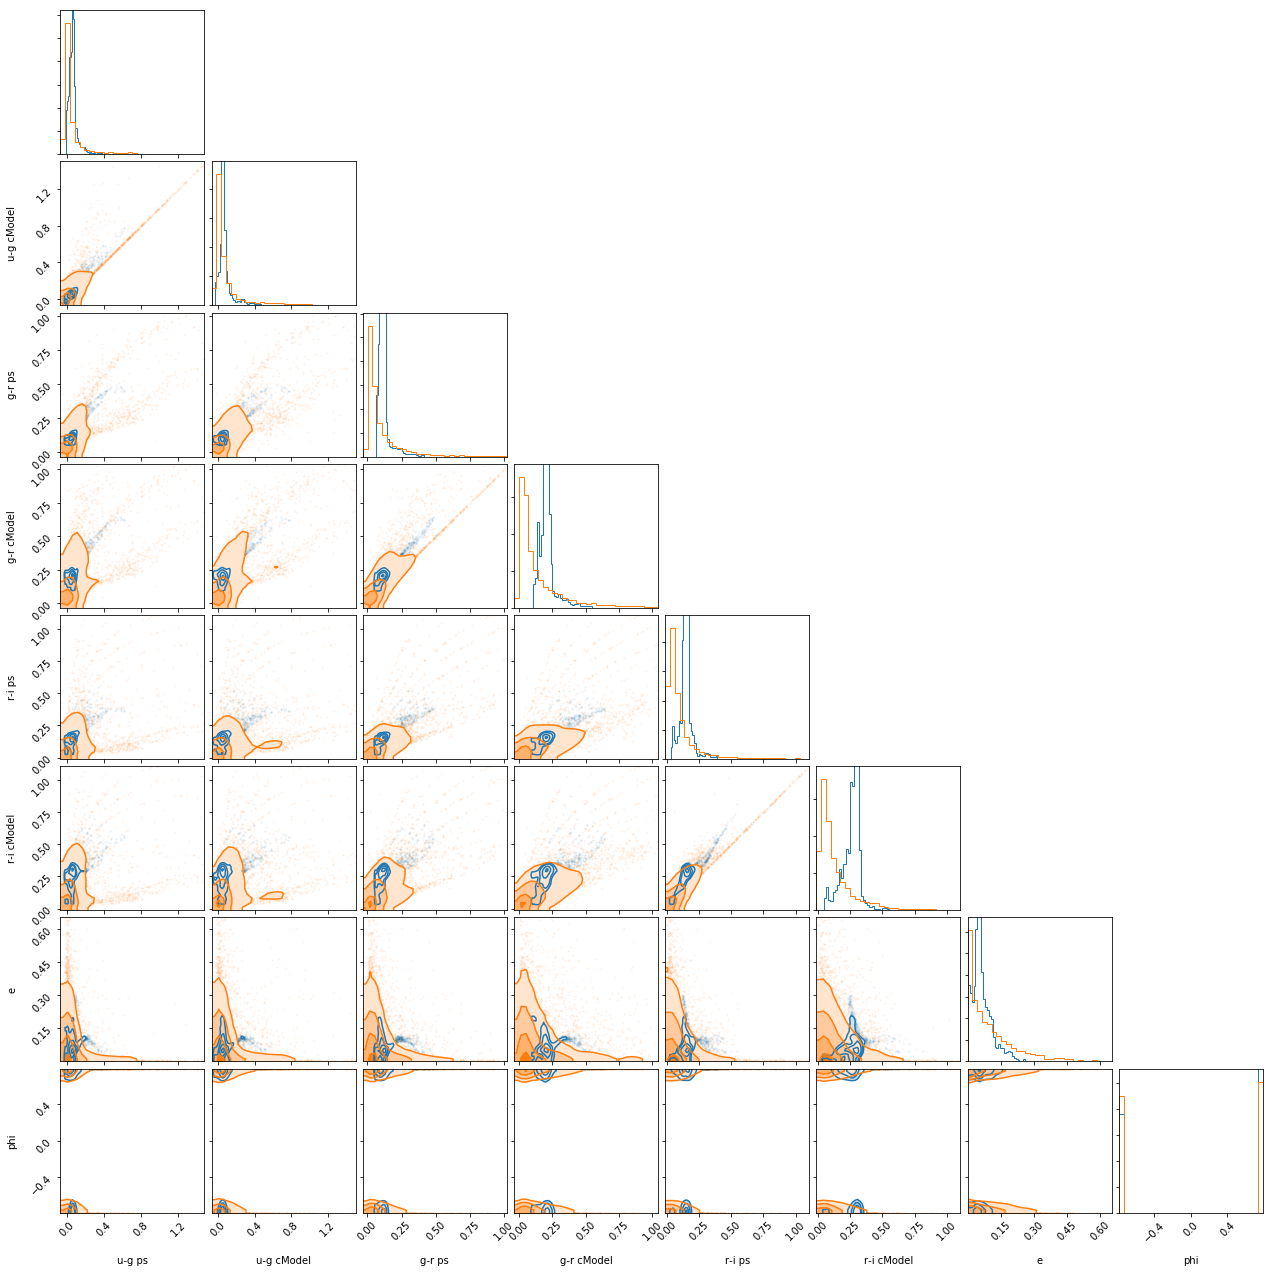

In [63]:
def draw_cornerplot(pred, cols, fig=None, color='black'):
    n_data, n_params = pred.shape
    plot = corner.corner(pred,
                        color=color, 
                        smooth=1.0, 
                        labels=['u-g ps', 'u-g cModel', 'g-r ps', 'g-r cModel',
                               'r-i ps', 'r-i cModel', 'e', 'phi'],
                        #show_titles=True,
                        fill_contours=True,
                        bins=30,
                        fig=fig,
                        range=[0.99]*n_params,
                        hist_kwargs=dict(density=True, ))
    return plot

pairwise_post_pred = draw_cornerplot(corner_2d_pred, color='tab:blue')
pairwise_post_observed = draw_cornerplot(corner_2d_obs, fig=pairwise_post_pred, color='tab:orange')

In [16]:
import treecorr
#import fitsio
import numpy
import time
import pprint
import matplotlib
import matplotlib.pyplot as plt

In [17]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

In [26]:
dropout_result['mu_class'].shape, X_nat.shape

((12701, 1), (12701, 42))

In [29]:
sample_df.shape

(308822, 38)

In [19]:
results = (probs > 0.5)
results.shape

(12701,)

Text(0.15,0.25,'9861 (77.6%)')

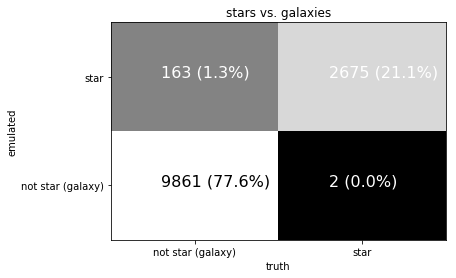

In [24]:
obs = X_nat['star'].astype(int)
em = results.astype(int)

count, _, _, _ = plt.hist2d(obs, em, norm=matplotlib.colors.LogNorm(), bins=2, cmap=plt.cm.get_cmap("gray")) #marker='.', alpha=0.2, label='_nolegend_')
plt.xlabel('truth')
plt.ylabel('emulated')
plt.title('stars vs. galaxies')
plt.xticks([0.25, 0.75], ['not star (galaxy)', 'star'])
#plt.xticklabels()
plt.yticks([0.25, 0.75], ['not star (galaxy)', 'star'])
#plt.yticklabels(['not star (galaxy)', 'star'])

neg_x = 0.15 
pos_x = 0.65
total = np.sum(count)
plt.text(pos_x, 0.75, "{} ({:.1f}%)".format(int(count[1, 1]), count[1, 1]/total*100.0), fontsize=16, color='white') # true positives
plt.text(neg_x, 0.75, "{} ({:.1f}%)".format(int(count[0, 1]), count[0, 1]/total*100.0), fontsize=16, color='white') # false positives
plt.text(pos_x, 0.25, "{} ({:.1f}%)".format(int(count[1, 0]), count[1, 0]/total*100.0), fontsize=16, color='white') # false negatives
plt.text(neg_x, 0.25, "{} ({:.1f}%)".format(int(count[0, 0]), count[0, 0]/total*100.0), fontsize=16) # true negatives

In [18]:
only_gal = ~X_nat.loc[:, 'star'].astype(bool)
only_star = X_nat.loc[:, 'star'].astype(bool)
obj_type='gal only'
if obj_type=='stars only':
    which_obj = only_star
    print('stars only')
else:
    which_obj = only_gal
    print('gal only')
    
probs = dropout_result['mu_class'].reshape(-1)


ra_obs = Y_nat.loc[which_obj, 'ra_obs'].values
dec_obs = Y_nat.loc[which_obj, 'dec_obs'].values

mask = ~sample_df['star'].values.astype(bool)
ra_em = sample_df.loc[mask, 'ra'].values
dec_em = sample_df.loc[mask, 'dec'].values

def get_e1e2(arr, mask, sample=False):
    if sample:
        mask = ~arr['star'].values.astype(bool)
    
    diff_mom = arr.loc[mask, 'Ixx'].values - arr.loc[mask, 'Ixx'].values
    trace_mom = arr.loc[mask, 'Ixx'].values +  arr.loc[mask, 'Ixx'].values
    e1 = diff_mom/trace_mom
    e2 = 2.0*arr.loc[mask, 'Ixy'].values/trace_mom
    return e1, e2
    
e1_obs, e2_obs = get_e1e2(Y_nat, which_obj, False)
e1_em, e2_em = get_e1e2(sample_df, which_obj, True)
kappa = np.zeros_like(e1_obs)

obs_cat = treecorr.Catalog(ra=ra_obs, dec=dec_obs, g1=e1_obs, g2=e2_obs, k=np.zeros_like(e1_obs), 
                                ra_units='deg', dec_units='deg')
gg_obs = treecorr.GGCorrelation(min_sep=1, max_sep=100, nbins=15, sep_units='arcmin')

em_cat = treecorr.Catalog(ra=ra_em, dec=dec_em, g1=e1_em, g2=e2_em, k=np.zeros_like(e2_em), 
                                ra_units='deg', dec_units='deg')
gg_em = treecorr.GGCorrelation(min_sep=1, max_sep=100, nbins=15, sep_units='arcmin')

print('bin_size = %.6f'%gg_obs.bin_size)
t1 = time.time()
gg_obs.process(obs_cat)  # Takes approx 1 minute / million objects
gg_em.process(em_cat)
t2 = time.time()
print('Time for calculating gg correlation = ',t2-t1)


gal only


KeyError: 'the label [ra] is not in the [columns]'

In [104]:
def plot_xi_plus(gg, which_data):
    r = numpy.exp(gg.meanlogr)
    xip = gg.xip
    xim = gg.xim
    sig = numpy.sqrt(gg.varxip)
    lw=2.0

    if which_data=='observed':
        color='tab:orange'
    else: # emulated
        color='tab:blue'
    
    plt.plot(r, xip, color=color)
    plt.plot(r, -xip, color=color, ls=':')
    plt.errorbar(r[xip>0], xip[xip>0], yerr=sig[xip>0], color=color, lw=lw, ls='')
    plt.errorbar(r[xip<0], -xip[xip<0], yerr=sig[xip<0], color=color, lw=lw, ls='')
    lp = plt.errorbar(-r, xip, yerr=sig, color=color, 
                      label=r'$\xi_+(\theta)$ %s' %which_data)

    plt.xscale('log')
    plt.yscale('log', nonposy='clip')
    plt.xlabel(r'$\theta$ (arcmin)')
    plt.legend()

In [105]:
def plot_xi_minus(gg, which_data):
    r = numpy.exp(gg.meanlogr)
    xip = gg.xip
    xim = gg.xim
    sig = numpy.sqrt(gg.varxip)
    lw=2.0
    
    if which_data=='observed':
        color='tab:orange'
    else: # emulated
        color='tab:blue'
        
    plt.plot(r, xim, color=color)
    plt.plot(r, -xim, color=color, ls=':')
    plt.errorbar(r[xim>0], xim[xim>0], yerr=sig[xim>0], color=color, lw=lw, ls='')
    plt.errorbar(r[xim<0], -xim[xim<0], yerr=sig[xim<0], color=color, lw=lw, ls='')
    lm = plt.errorbar(-r, xim, yerr=sig, color=color, 
                      label=r'$\xi_-(\theta)$ %s' %which_data)
    
    plt.xscale('log')
    plt.yscale('log', nonposy='clip')
    plt.xlabel(r'$\theta$ (arcmin)')

    plt.legend()
    

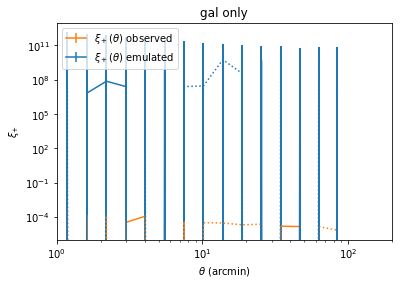

In [106]:
plt.title(obj_type)
plt.xlim( [1,200] )
plt.ylabel(r'$\xi_{+}$')
plot_xi_plus(gg_obs, 'observed')
plot_xi_plus(gg_em, 'emulated')

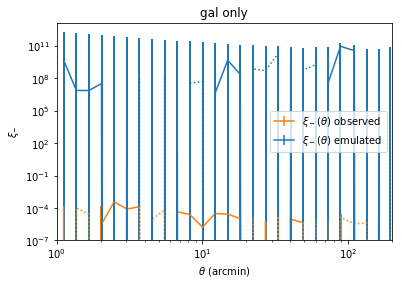

In [57]:
plt.title(obj_type)
plt.xlim( [1,200] )
plt.ylabel(r'$\xi_{-}$')
plot_xi_minus(gg_obs, 'observed')
plot_xi_minus(gg_em, 'emulated')

In [52]:
dd_obs = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
dd_obs.process(obs_cat)
#plot_nn(dd_obs, obs_cat, zoom_in=False)
plot_nn_corr(dd_obs)

NameError: name 'plot_nn_corr' is not defined

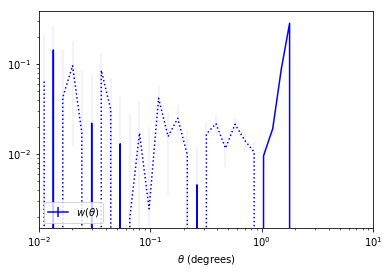

In [244]:
dd_em = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
dd_em.process(em_cat)
#rand_ra, rand_dec = plot_nn(dd_em, em_cat, zoom_in=False)
plot_nn_corr(dd_em)

In [212]:
def plot_nn(dd, cat, zoom_in=False):
    ra_min = np.min(cat.ra)
    ra_max = np.max(cat.ra)
    dec_min = np.min(cat.dec)
    dec_max = np.max(cat.dec)
    print('ra range = %f .. %f' % (ra_min, ra_max))
    print('dec range = %f .. %f' % (dec_min, dec_max))

    rand_ra = np.random.uniform(ra_min, ra_max, 10**4)
    rand_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), 10**4)
    rand_dec = np.arcsin(rand_sindec)
    
    rand_ra_pi = rand_ra / np.pi
    rand_cosdec = np.cos(rand_dec)

    if zoom_in:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.scatter(rand_ra* 180/np.pi, rand_dec* 180/np.pi, color='green', marker='o')
        ax1.set_xlabel('RA * cos(Dec)')
        ax1.set_ylabel('Dec')
        ax1.set_xlim(55.75, 56.25)
        ax1.set_ylim(-29.8, -29.2)
        ax1.set_title('Randoms')

        ax2.scatter(cat.ra* 180/np.pi, cat.dec* 180/np.pi, color='blue', marker='o')
        #print(cat.ra)
        ax2.set_xlabel('RA * cos(Dec)')
        ax2.set_ylabel('Dec')
        ax2.set_xlim(55.75, 56.25)
        ax2.set_ylim(-29.8, -29.2)
        ax2.set_title('Data')
    else:
        # Check that the randoms cover the same space as the data
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.scatter(cat.ra * 180/np.pi, cat.dec * 180/np.pi, color='blue', marker='o', alpha=0.2)
        ax1.scatter(rand_ra * 180/np.pi, rand_dec * 180/np.pi, color='green', marker='o', alpha=0.2)
        ax1.set_xlabel('RA (degrees)')
        ax1.set_ylabel('Dec (degrees)')
        ax1.set_title('Randoms on top of data')

        # Repeat in the opposite order
        ax2.scatter(rand_ra * 180/np.pi, rand_dec * 180/np.pi, color='green',marker='o', alpha=0.2)
        ax2.scatter(cat.ra * 180/np.pi, cat.dec * 180/np.pi, color='blue', marker='o', alpha=0.2)
        ax2.set_xlabel('RA (degrees)')
        ax2.set_ylabel('Dec (degrees)')
        ax2.set_title('Data on top of randoms')
    return rand_ra, rand_dec

In [214]:
rand = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='radians', dec_units='radians')
rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
rr.process(rand)

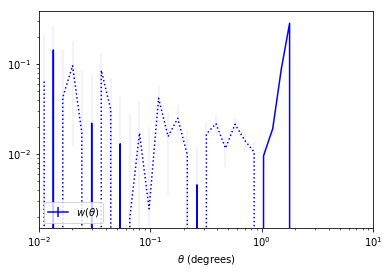

In [215]:
def plot_nn_corr(dd):
    xi, varxi = dd.calculateXi(rr)

    r = numpy.exp(dd.meanlogr)
    sig = numpy.sqrt(varxi)

    plt.plot(r, xi, color='blue')
    plt.plot(r, -xi, color='blue', ls=':')
    plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.1, ls='')
    plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
    leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

    plt.xscale('log')
    plt.yscale('log', nonposy='clip')
    plt.xlabel(r'$\theta$ (degrees)')

    plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
    plt.xlim([0.01,10])
    plt.show()
    


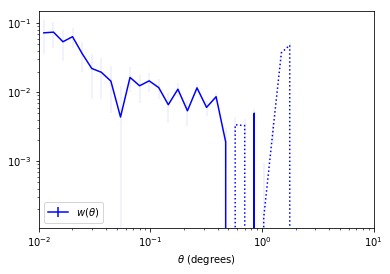

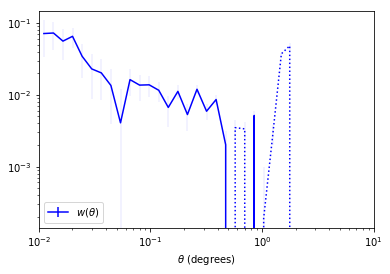

In [241]:

plot_nn_corr(dd_em)

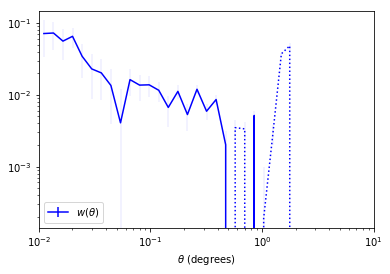